In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import pickle
import torch
import io
import random
from gensim.models import Word2Vec

In [2]:
# function to work around loading a GPU generated pickle on local CPU machine
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [3]:
# load synthesizer from saved object
with open('models/TVAE_synthesizer_test.pkl', 'rb') as input:
    synthesizer = CPU_Unpickler(input).load()

# modify device from cuda:0 to cpu
synthesizer.device = 'cpu'

In [4]:
# load synthesizer from local machine
#with open('models/TVAE_synthesizer_test.pkl', 'rb') as input:
#    synthesizer = pickle.load(input)

In [5]:
# check out sample
N = 1000
sample = synthesizer.sample(N)
np.set_printoptions(suppress = True, precision = 2)

In [6]:
df_input = pd.read_csv('data/cc_data_input_10emb.csv')

In [7]:
input_columns = list(df_input.columns)[1:]

In [8]:
df_sample = pd.DataFrame(sample, columns=input_columns) 
pd.set_option('display.max_columns', 36)
df_sample.head()

,Purchase Amount,Age,Account Type_bank_account,Account Type_credit_card,Consumer Gender_female,Consumer Gender_male,SIC Description_Book Stores,"SIC Description_Communications Services, Not Elsewhere Classified",SIC Description_Drug Stores and Proprietary Stores,SIC Description_Eating Places,SIC Description_Family Clothing Stores,SIC Description_Gasoline Service Stations,SIC Description_Grocery Stores,SIC Description_Miscellaneous Food Stores,SIC Description_Other,SIC Description_Taxicabs,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,period_of_month_end,period_of_month_mid,period_of_month_start,retailerVec_01,retailerVec_02,retailerVec_03,retailerVec_04,retailerVec_05,retailerVec_06,retailerVec_07,retailerVec_08,retailerVec_09,retailerVec_10
0,17.016740,29.996369,0.999326,-0.000415,0.999784,0.000017,0.000178,0.000036,-0.000136,0.999412,0.000006,-0.000308,0.000185,-0.000003,-0.000298,-0.000064,0.000100,-3.274166e-07,0.000005,0.000196,-0.000138,-0.000132,0.000126,0.000231,-0.000138,0.000191,0.422661,-0.716853,0.405262,0.588540,-0.465476,0.254035,0.032272,-0.504530,-1.012983,0.837853
1,7.295441,30.997041,1.000330,0.000002,1.000401,-0.000318,-0.000070,-0.000123,-0.000163,0.999887,0.000062,-0.000010,0.000230,0.000038,0.000311,-0.000098,0.000503,-1.600268e-04,0.000028,-0.000296,-0.000234,0.000183,-0.000158,-0.000185,0.000103,0.000014,0.538992,-1.074299,0.637448,0.971715,-0.639919,0.613493,-0.516841,-0.557063,-0.932832,0.013398
2,51.262058,56.526752,0.000577,0.999912,-0.000626,0.999725,0.999058,0.000051,-0.000132,-0.000140,-0.000105,0.000054,-0.000081,0.000027,0.000116,0.000047,0.000045,-1.471175e-04,0.000184,0.000149,0.000013,-0.000295,-0.000118,0.000009,0.000423,0.000226,1.252389,-3.779856,-1.144274,1.484083,-2.174043,-2.308312,-1.344999,-2.399904,-2.206896,1.653631
3,9.373025,32.945018,-0.000919,1.000588,0.000229,1.000277,-0.000065,0.000021,-0.000028,1.000642,0.000063,-0.000032,0.000127,-0.000173,-0.000117,-0.000131,0.000039,-2.903922e-05,0.000336,0.000049,0.000121,0.000088,-0.000085,-0.000075,0.000065,0.000054,0.458200,-0.527184,0.600806,0.971435,-0.170540,0.201018,-0.365504,-0.630423,-0.351327,0.082137
4,33.180653,23.339296,0.000247,1.000252,0.999984,0.000284,0.000252,-0.000055,0.000022,-0.000540,-0.000019,-0.000083,1.000265,0.000109,0.000339,-0.000045,0.000167,4.854269e-04,0.000049,-0.000066,0.000231,-0.000247,0.000263,-0.000477,-0.000203,0.000198,0.356364,-1.847875,0.417197,-0.164549,0.120613,-2.557130,-0.490442,-2.379612,-0.375269,-0.454946


In [9]:
# return series of dummy variables with given column name
def reverse_dummy(df, col_name):
    # get index of columns that starts with col_name, for example, Gender_male, Gender_female for col_name = `Gender`
    idx = [i for i, s in enumerate(list(df.columns)) if col_name in s]
    tmp = df.iloc[:,idx]
    # find column name for max in each row and put into one series
    df_output = pd.Series(tmp.idxmax(axis=1), name = col_name)
    
    # remove strings with col_name plus underscore
    df_output = df_output.map(lambda x: x.replace(col_name + '_',''))
    return df_output

In [10]:
df_num = df_sample.iloc[:,[0,1]]
df_account = reverse_dummy(df_sample,'Account Type')
df_gender = reverse_dummy(df_sample,'Consumer Gender')
df_SIC = reverse_dummy(df_sample,'SIC Description')
df_dw = reverse_dummy(df_sample,'day_of_week')
df_pm = reverse_dummy(df_sample,'period_of_month')

In [11]:
df_reverse = pd.concat([df_num,df_account,df_gender,df_SIC,df_dw,df_pm], axis=1)

# round age column
df_reverse['Age'] = df_reverse['Age'].apply(lambda x: round(x, 0))

# remove negative purchase amount
df_reverse = df_reverse[(df_reverse['Purchase Amount'] > 0)]
df_reverse.reset_index(drop=True, inplace=True)

#pd.set_option('display.max_rows', N)
print(df_reverse.shape)
df_reverse.head()

(935, 7)


,Purchase Amount,Age,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month
0,17.016740,30.0,bank_account,female,Eating Places,Sunday,end
1,7.295441,31.0,bank_account,female,Eating Places,Friday,mid
2,51.262058,57.0,credit_card,male,Book Stores,Saturday,mid
3,9.373025,33.0,credit_card,male,Eating Places,Saturday,mid
4,33.180653,23.0,credit_card,female,Grocery Stores,Monday,start


In [12]:
#df_reverse['SIC Description'].value_counts().index.to_list()

In [13]:
# reverse retailerVec back to retailers
idx = [i for i, s in enumerate(list(df_sample.columns)) if 'retailerVec' in s]
df_retailerVec = df_sample.iloc[:,idx]

# load the retailer_map
with open('models/retailer_map.pkl', 'rb') as input:
    retailer_map = pickle.load(input)    

model = Word2Vec.load('models/perSICperPerson_10emb.model')
    
# only keep values in the model (more than 5 times appearance)
for key, value in retailer_map.items():
    retailer_map[key] = list(set(value) & set(model.wv.vocab))
    
# group other SIC (after top N) into other
list2keep = ['Eating Places', 'Grocery Stores', 'Gasoline Service Stations', 'Book Stores', 'Drug Stores and Proprietary Stores', 'Miscellaneous Food Stores', 'Family Clothing Stores', 'Taxicabs', 'Communications Services, Not Elsewhere Classified']
other_list = []    
for key, value in retailer_map.items():
    if key not in list2keep:
        other_list = other_list + value

# delete other group key-values in retailer_map
retailer_map_grouped = {k: retailer_map[k] for k in list2keep}

# add other key-value pairs
retailer_map_grouped['Other'] = other_list

# put retailer vectors into one column
df_retailerVec['retailerVec']= df_retailerVec.values.tolist()
df_SIC_vector = pd.concat([df_SIC,df_retailerVec['retailerVec']],axis = 1)
df_SIC_vector.head()

d:\anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,SIC Description,retailerVec
0,Eating Places,"[0.42266091601982725, -0.7168526278990933, 0.4..."
1,Eating Places,"[0.5389924007981011, -1.0742987975191896, 0.63..."
2,Book Stores,"[1.2523890123407107, -3.779855544794898, -1.14..."
3,Eating Places,"[0.4582001976337663, -0.5271839948567076, 0.60..."
4,Grocery Stores,"[0.35636386627606864, -1.8478745627845732, 0.4..."


In [14]:
retailer_map_grouped.keys()
#retailer_map_grouped['Radiotelephone Communications']
#df_SIC_vector['SIC Description'].value_counts()

dict_keys(['Eating Places', 'Grocery Stores', 'Gasoline Service Stations', 'Book Stores', 'Drug Stores and Proprietary Stores', 'Miscellaneous Food Stores', 'Family Clothing Stores', 'Taxicabs', 'Communications Services, Not Elsewhere Classified', 'Other'])

In [15]:
# find out retailer in the same SIC and also with the most similar vector
def return_retailer_SIC(model, retailer_map_grouped, sector, vector):
    if pd.isnull(sector):
        return None
    else:
        word_list = retailer_map_grouped[sector]
        min_idx = model.wv.distances(vector, other_words = word_list).argmin()
        return word_list[min_idx]

In [16]:
df_reverse['Normalized Retailer'] = df_SIC_vector.apply(lambda x: return_retailer_SIC(model, retailer_map_grouped, x['SIC Description'],x['retailerVec']), axis = 1)
df_reverse.head()

,Purchase Amount,Age,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month,Normalized Retailer
0,17.016740,30.0,bank_account,female,Eating Places,Sunday,end,Burger King
1,7.295441,31.0,bank_account,female,Eating Places,Friday,mid,Manchu Wok
2,51.262058,57.0,credit_card,male,Book Stores,Saturday,mid,Amazon
3,9.373025,33.0,credit_card,male,Eating Places,Saturday,mid,Pancake House
4,33.180653,23.0,credit_card,female,Grocery Stores,Monday,start,Marcello's


In [17]:
# given period_of_month (start, mid or end) and year (1989) and month (6), return index of the possible days
def return_day_index(period_of_month, year, month):
    if period_of_month == 'start':
        return list(range(1,11))
    elif period_of_month == 'mid':
        return list(range(11,21))
    else:
        return list(range(21, pd.Period(str(year) + '-' + str(month)).days_in_month + 1))
    
# function to convert day_of_week and period_of_month back to Date, given a year and a month
# Example:
# input: day_of_week = 'Monday'; period_of_month = 'start'; Y = 2020; M = 2
# output: 2020-02-03 00:00:00

def return_date(day_of_week, period_of_month, Y, M):
    # return list of days
    D = return_day_index(period_of_month, Y, M)

    tmp = pd.DataFrame({'year': [str(Y) for i in range(len(D))],
                        'month': [str(M) for i in range(len(D))],
                        'day': D})
    
    # create table with each row of year, month and day in given period
    date_period = pd.to_datetime(tmp[['year', 'month', 'day']])

    # locate index of which date is the given day_of_week
    idx_list = [i for i, s in enumerate(date_period.dt.strftime('%A')) if day_of_week in s]

    # randomly pick up one index, since it's possible one period has multiple given weekday (say Monday)
    idx = random.choice(idx_list)

    return date_period[idx]

In [18]:
Y = 2022; M = 2
df_reverse['Transaction Date'] = df_reverse.apply(lambda x: return_date(x.day_of_week, x.period_of_month, Y, M), axis = 1)
#df_reverse.drop(['day_of_week','period_of_month'], axis = 1, inplace = True, errors = 'ignore')
df_reverse.head()

,Purchase Amount,Age,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month,Normalized Retailer,Transaction Date
0,17.016740,30.0,bank_account,female,Eating Places,Sunday,end,Burger King,2022-02-27
1,7.295441,31.0,bank_account,female,Eating Places,Friday,mid,Manchu Wok,2022-02-11
2,51.262058,57.0,credit_card,male,Book Stores,Saturday,mid,Amazon,2022-02-19
3,9.373025,33.0,credit_card,male,Eating Places,Saturday,mid,Pancake House,2022-02-12
4,33.180653,23.0,credit_card,female,Grocery Stores,Monday,start,Marcello's,2022-02-07


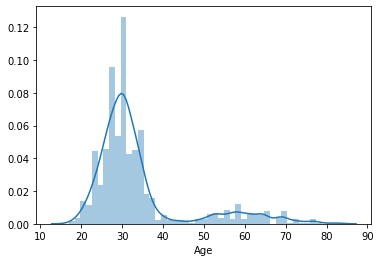

In [19]:
sns.distplot(df_reverse['Age']);

In [20]:
# view counts and percentage for each column's elements
def view_column_counts(df, col_name):
    df_pivot = df.groupby(by = col_name).size().reset_index(name='Counts')
    df_pivot['Per (%)'] = (df_pivot['Counts'])/df.shape[0]*100
    df_pivot.sort_values(by = 'Counts',ascending = False,inplace = True)
    return df_pivot

In [21]:
# gender, account type, sector and retailer percentage
text_col_list = ['Account Type', 'Consumer Gender','Normalized Retailer', 'SIC Description']

for col_name in text_col_list:   
    print(col_name)
    df_pivot = view_column_counts(df_reverse,col_name)
    print(df_pivot)
    print('\n')

Account Type
   Account Type  Counts    Per (%)
1   credit_card     533  57.005348
0  bank_account     402  42.994652


Consumer Gender
  Consumer Gender  Counts    Per (%)
0          female     537  57.433155
1            male     398  42.566845


Normalized Retailer
      Normalized Retailer  Counts   Per (%)
302           Tim Hortons      78  8.342246
207          Petro-Canada      42  4.491979
170            McDonald's      39  4.171123
5                  Amazon      35  3.743316
318               Walmart      34  3.636364
..                    ...     ...       ...
184              Nathan's       1  0.106952
185         Natural Foods       1  0.106952
186     Nature's Emporium       1  0.106952
187  Nature's Fare Market       1  0.106952
163          Market Fresh       1  0.106952

[326 rows x 3 columns]


SIC Description
                                     SIC Description  Counts    Per (%)
3                                      Eating Places     274  29.304813
6                

barplot for SIC Description


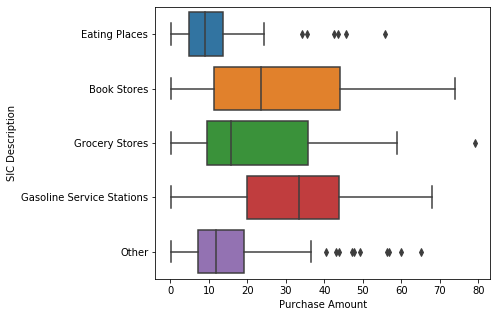

barplot for Normalized Retailer


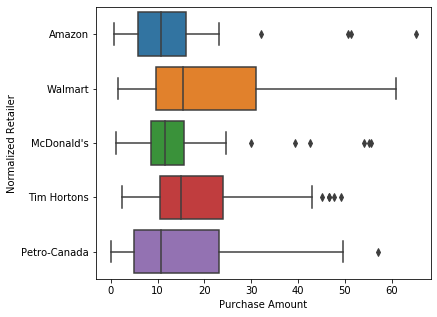

In [22]:
check_list = ['SIC Description','Normalized Retailer']
fig_dims = [6, 5] 
N = 5
threshold = 100

for cat in check_list:   
    print("barplot for %s" % (cat))
    list_tmp = df_reverse[cat].value_counts()[:N].index.tolist() # top N counts in that category
    df_tmp = df_reverse[df_reverse[cat].isin(list_tmp) & (df_reverse['Purchase Amount'] < threshold)]
    fig, ax = plt.subplots(figsize = fig_dims)
    chart = sns.boxplot(y = df_tmp[cat], x = df_tmp['Purchase Amount'])
    plt.show()